In [229]:
import polars as pl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import gc
import time
import numpy as np
import joblib


In [230]:
# Step 1: Read Data with Lags
def read_data_with_lags(current_file_path, previous_file_path, columns_needed, lag_column="responder_6", lag_name="responder_6_lag_1", length = 5000):
    """Read the current file and add lagged data from the previous file."""
    # Read current data
    current_file = pl.scan_parquet(current_file_path).select(columns_needed).head(length).collect()
    
    # If there is a previous file, add lagged data
    if previous_file_path:
        previous_file = pl.scan_parquet(previous_file_path).select(["time_id", lag_column]).head(length).collect()
        lagged_data = previous_file.rename({lag_column: lag_name})
        current_file = current_file.join(lagged_data, on="time_id", how="left")
    
    return current_file

# Step 2: Clean Data
def clean_data(df):
    """Clean the data by handling missing values."""
    if isinstance(df, pl.DataFrame):
        df = df.fill_null(strategy="backward").fill_null(strategy="forward").fill_null(0)
    else:
        raise TypeError("The input is not a Polars DataFrame.")
    return df

# Step 3: Preprocess Data
def preprocess_data(df, target_column='responder_6', n_components=0.95):
    """Apply PCA to reduce dimensions."""
    # Drop the target column and convert to numpy
    X = df.drop(target_column).to_numpy()
    y = df[target_column].to_numpy()

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    joblib.dump(pca, 'pca.pkl')
    return X_pca, y

# Step 4: Anonymize
def anonymize(file): 
    return file

In [231]:
from xgboost import XGBRegressor

def select_features_by_importance(df, target_column='responder_6', threshold=0.01):
 
    X = df.drop(target_column).to_pandas()
    y = df[target_column].to_pandas()
    
    # Train a temporary XGBoost model to get feature importance
    model = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)
    model.fit(X, y)
    
    # Get feature importance
    feature_importances = model.feature_importances_
    important_features = X.columns[feature_importances >= threshold]
    
    # Save the selected features (excluding target column)
    selected_features = list(important_features)
    joblib.dump(selected_features, 'selected_features.pkl')  # Save the selected features

    # Filter the original DataFrame for these features
    filtered_df = df.select(selected_features + [target_column])
    return filtered_df


Model Functions

In [232]:
# Step 5: Train Model
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


def train_XGB(X, y):
    """Train the model using XGBoost."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    mean_mae = np.mean(cv_scores)
    print(f"Cross-Validated Mean Absolute Error (MAE): {mean_mae}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    return model , y_test, y_pred

In [233]:
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

def train_SVM(X, y, model_type='SVR'):
    """Train the model using Support Vector Machine (SVM) """
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    if model_type == 'SVR':
        model = SVR(kernel='rbf', C=1.0, gamma="scale")
    else:
        model = SGDRegressor(max_iter=1000, tol=1e-3, penalty='l2', alpha=0.0001, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error SVM (MAE): {mae}")
    return model

In [234]:
def pipeline(current_file_path, previous_file_path, columns_needed ,model, counter):

    start_time = time.time()
    df = read_data_with_lags(current_file_path, previous_file_path, columns_needed)
    df = clean_data(df)
    df = anonymize(df)
    df = select_features_by_importance(df, target_column='responder_6', threshold=0.001)

    X, y = preprocess_data(df, target_column='responder_6', n_components=0.95)
    
    if model =='XGB':
        model,y_test, y_pred = train_XGB(X, y)
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_test)), y_test, label='Actual (y_test)', color='green')
        plt.plot(range(len(y_pred)), y_pred, label='Predicted (y_pred)', color='blue', linestyle='--')
        plt.xlabel("Sample Index")
        plt.ylabel("Values")
        plt.title("Actual vs. Predicted")
        plt.legend()
        plt.grid()
        plt.show()
    elif model == 'SVM': 
        model = train_SVM(X,y, 'SGD')
    else: 
        raise NameError('Model name not found')

    # Clear memory
    del df, X, y
    gc.collect()  # Force garbage collection
    
    end_time = time.time()
    print(f"Finished processing file {counter+1}/{len(file_paths)} in {end_time - start_time:.2f} seconds\n")
    
    # Update previous file path
    previous_file_path = current_file_path

    return previous_file_path, model


In [235]:
columns_needed = [
    'date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
    'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
    'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11',
    'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
    'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21',
    'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26',
    'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
    'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
    'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
    'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
    'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
    'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
    'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61',
    'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66',
    'feature_67', 'feature_68', 'feature_69', 'feature_70', 'feature_71',
    'feature_72', 'feature_73', 'feature_74', 'feature_75', 'feature_76',
    'feature_77', 'feature_78', 'responder_6'
]

Call Functions 

Cross-Validated Mean Absolute Error (MAE): -0.5487155973911285
Mean Absolute Error (MAE): 0.18537771701812744


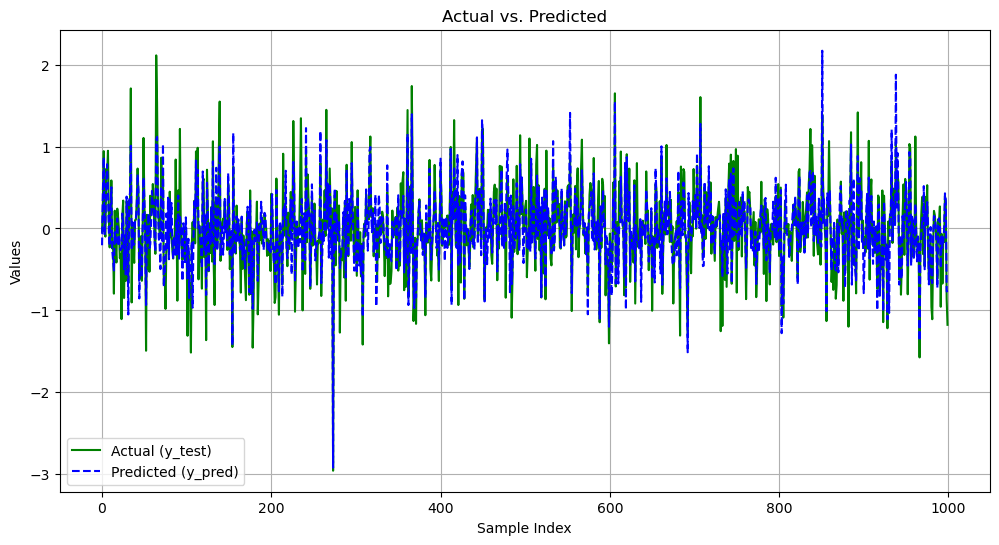

Finished processing file 1/10 in 1.12 seconds

Cross-Validated Mean Absolute Error (MAE): -0.7866752028465271
Mean Absolute Error (MAE): 0.15319891273975372


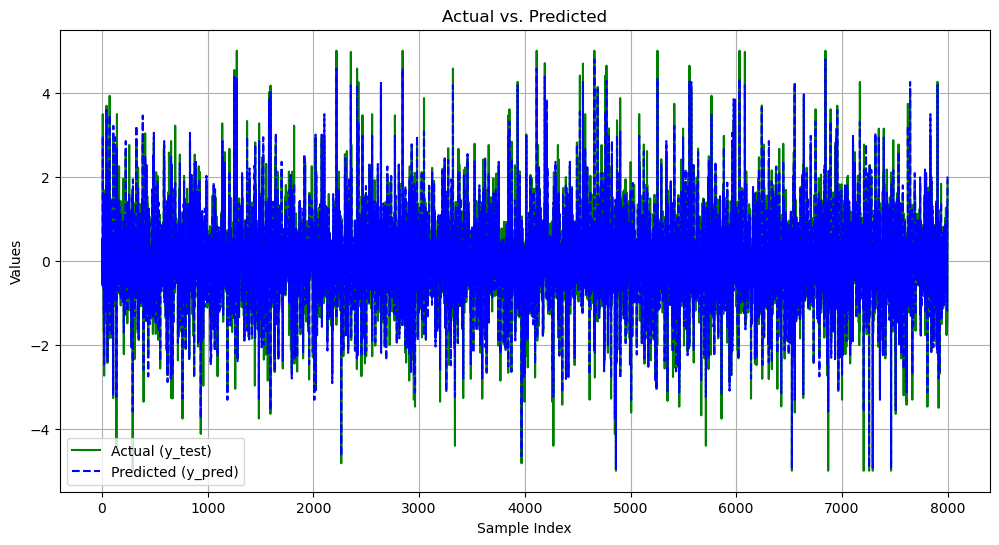

Finished processing file 2/10 in 1.80 seconds

Cross-Validated Mean Absolute Error (MAE): -0.9133638620376587
Mean Absolute Error (MAE): 0.17729082703590393


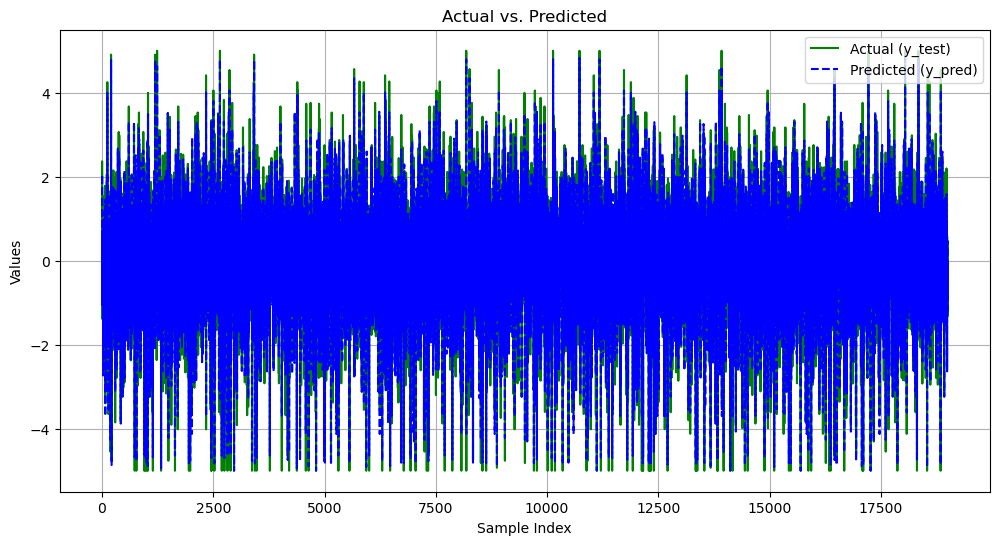

Finished processing file 3/10 in 2.55 seconds

Cross-Validated Mean Absolute Error (MAE): -0.9296494603157044
Mean Absolute Error (MAE): 0.1737721711397171


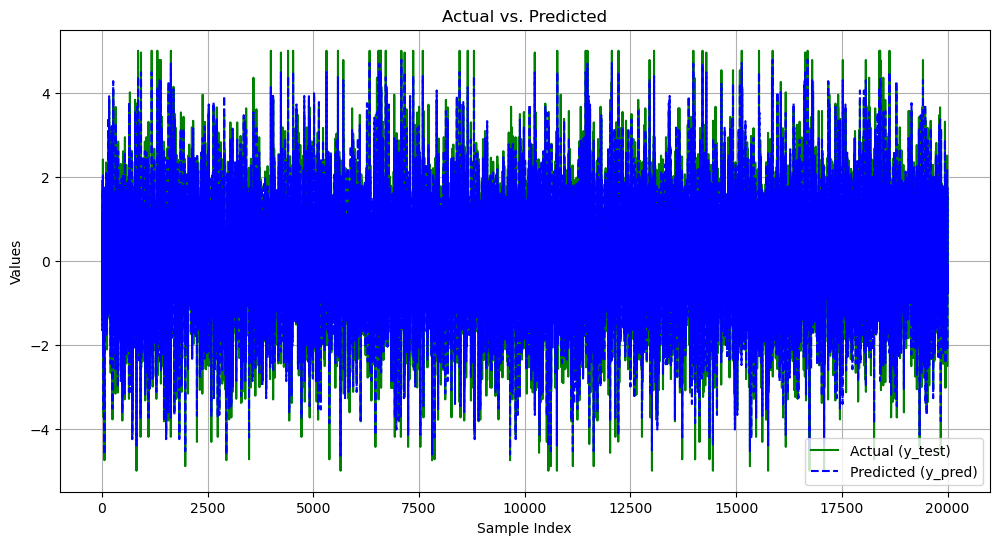

Finished processing file 4/10 in 2.29 seconds

Cross-Validated Mean Absolute Error (MAE): -1.1296710729599
Mean Absolute Error (MAE): 0.2400929182767868


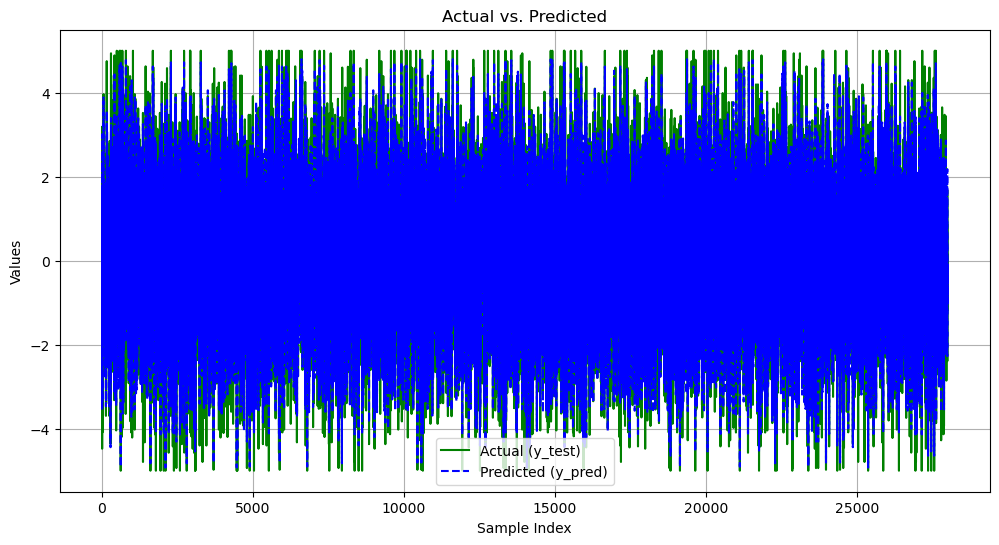

Finished processing file 5/10 in 2.78 seconds

Cross-Validated Mean Absolute Error (MAE): -0.5476338863372803
Mean Absolute Error (MAE): 0.1158883348107338


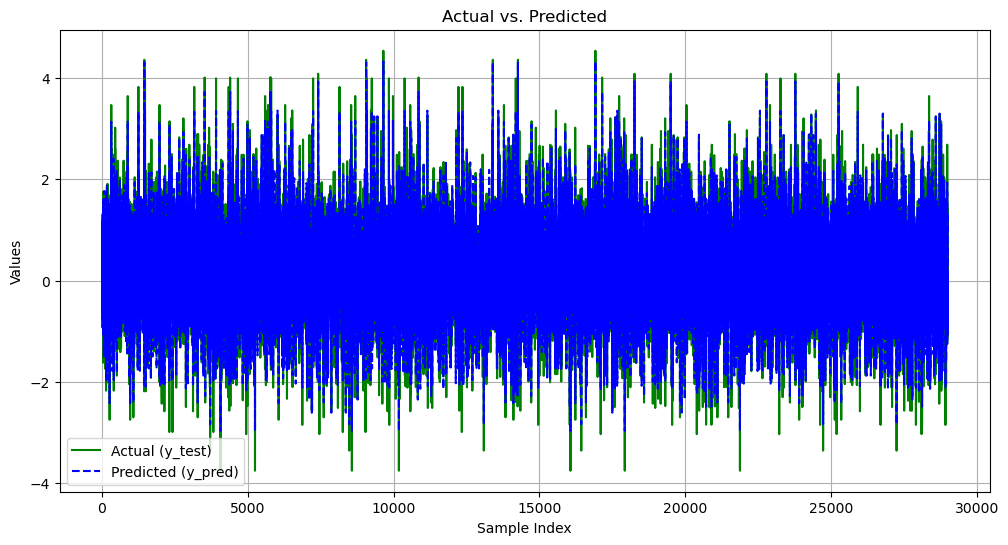

Finished processing file 6/10 in 3.04 seconds

Cross-Validated Mean Absolute Error (MAE): -0.8429012060165405
Mean Absolute Error (MAE): 0.20542840659618378


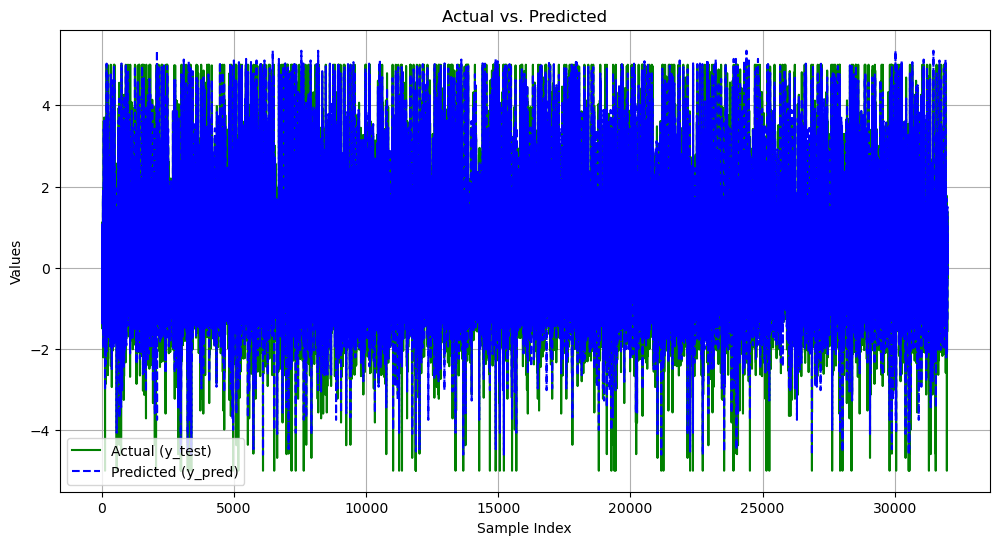

Finished processing file 7/10 in 3.20 seconds

Cross-Validated Mean Absolute Error (MAE): -1.2194951534271241
Mean Absolute Error (MAE): 0.25862544775009155


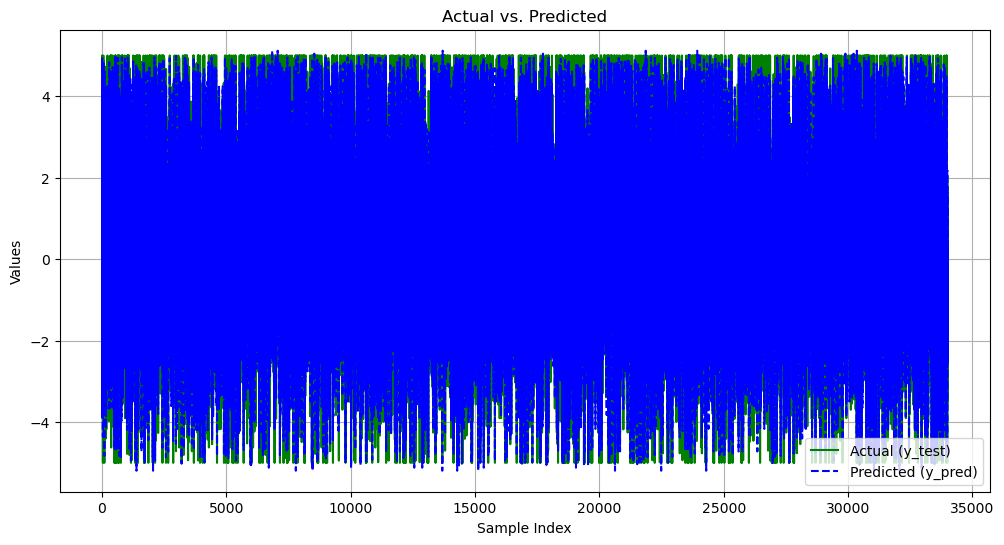

Finished processing file 8/10 in 3.19 seconds

Cross-Validated Mean Absolute Error (MAE): -0.8715415239334107
Mean Absolute Error (MAE): 0.18640731275081635


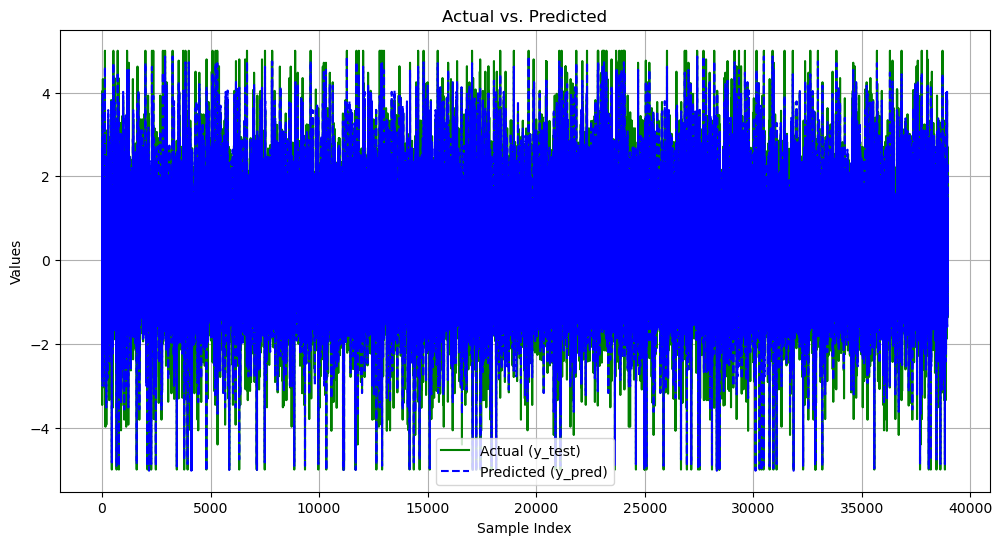

Finished processing file 9/10 in 3.44 seconds

Cross-Validated Mean Absolute Error (MAE): -0.6397621810436249
Mean Absolute Error (MAE): 0.151323139667511


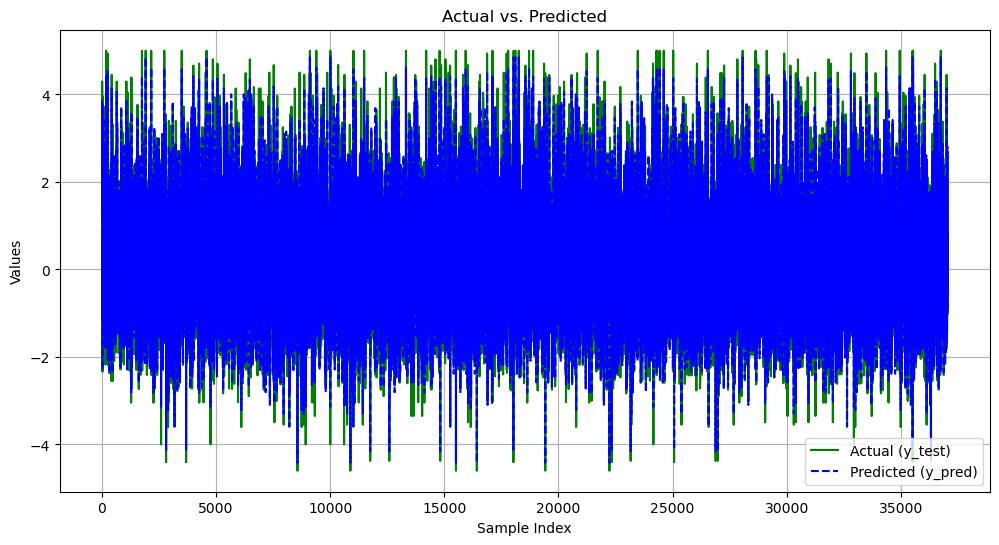

Finished processing file 10/10 in 3.14 seconds

Mean Absolute Error SVM (MAE): 0.38897731711769473
Finished processing file 1/10 in 0.37 seconds

Mean Absolute Error SVM (MAE): 0.6390028602799698
Finished processing file 2/10 in 0.66 seconds

Mean Absolute Error SVM (MAE): 0.7424988546925135
Finished processing file 3/10 in 1.02 seconds

Mean Absolute Error SVM (MAE): 0.8029550210859348
Finished processing file 4/10 in 1.02 seconds

Mean Absolute Error SVM (MAE): 0.9614965710937284
Finished processing file 5/10 in 1.35 seconds

Mean Absolute Error SVM (MAE): 0.4951160892260146
Finished processing file 6/10 in 1.15 seconds

Mean Absolute Error SVM (MAE): 0.8504887818959155
Finished processing file 7/10 in 1.51 seconds

Mean Absolute Error SVM (MAE): 1.2402140706717664
Finished processing file 8/10 in 1.39 seconds

Mean Absolute Error SVM (MAE): 0.7649219109402363
Finished processing file 9/10 in 1.97 seconds

Mean Absolute Error SVM (MAE): 0.6890662937604097
Finished processing file 10/

In [236]:

# Jupyter Notebook - File Paths 
file_paths = [
    f"/Users/nipace/Downloads/datas/train.parquet/partition_id={i}/part-0.parquet" for i in range(10)]

# Train XGB with PCA via pipeline without storing all in memory
previous_file_path = None
for i, current_file_path in enumerate(file_paths):
    previous_file_path, model = pipeline(current_file_path, previous_file_path, columns_needed, 'XGB', i)
joblib.dump(model, 'xgboost_model.pkl')

# Train SVM with PCA via pipeline without storing all in memory
previous_file_path = None
for i, current_file_path in enumerate(file_paths):
    previous_file_path, model = pipeline(current_file_path, previous_file_path, columns_needed, 'SVM', i)

In [237]:
import joblib
import polars as pl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np


# Step 1: Load the trained model
model = joblib.load('xgboost_model.pkl')  # or 'svm_model.pkl' if you're using SVM
pca = joblib.load('pca.pkl')        # Load the PCA model saved during training


# Step 2: Preprocess the Test Data (without the target column)
def preprocess_test_data(test_file_path, columns_needed):
   """Preprocess the test data using the saved PCA model."""
   selected_features = joblib.load('selected_features.pkl')
   # Read the test data
   df = pl.scan_parquet(test_file_path).select(columns_needed).collect()
   # Clean the data (similar to how it's done in your pipeline)
   df = df.fill_null(strategy="backward").fill_null(strategy="forward").fill_null(0)
   df = df.select(selected_features)
   # Convert Polars DataFrame to numpy
   X_test = df.to_numpy()
   # Apply the saved PCA model

   X_test_pca = pca.transform(X_test)  # Use transform, not fit_transform
   return df, X_test_pca


# Step 3: Prepare the test data
test_file_path = '/Users/nipace/Downloads/datas/test.parquet/date_id=0/part-0.parquet'
columns_needed = [
   'date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01',
   'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
   'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11',
   'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
   'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21',
   'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26',
   'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
   'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
   'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
   'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
   'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
   'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56',
   'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61',
   'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66',
   'feature_67', 'feature_68', 'feature_69', 'feature_70', 'feature_71',
   'feature_72', 'feature_73', 'feature_74', 'feature_75', 'feature_76',
   'feature_77', 'feature_78'
]  # List all the features used in training


df_test, X_test = preprocess_test_data(test_file_path, columns_needed)
print(df_test)


# Step 4: Make predictions using the trained model
predictions = model.predict(X_test)


# Step 5: Print or store the predictions
print(f"Predictions for responder_6 on the test data: {predictions}")


# Optionally, you can store predictions in a new DataFrame or a CSV
test_data_with_predictions = pl.DataFrame({
   'time_id': df_test['time_id'],  # Assuming 'time_id' is in the test data
   'predicted_responder_6': predictions
})


# Save the results to a CSV or Parquet file
test_data_with_predictions.write_csv('predictions.csv')
# Or if you want to write to Parquet
test_data_with_predictions.write_parquet('predictions.parquet')







shape: (39, 79)
┌─────────┬───────────┬──────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time_id ┆ symbol_id ┆ weight   ┆ feature_01 ┆ … ┆ feature_75 ┆ feature_7 ┆ feature_7 ┆ feature_7 │
│ ---     ┆ ---       ┆ ---      ┆ ---        ┆   ┆ ---        ┆ 6         ┆ 7         ┆ 8         │
│ i16     ┆ i8        ┆ f32      ┆ f32        ┆   ┆ f32        ┆ ---       ┆ ---       ┆ ---       │
│         ┆           ┆          ┆            ┆   ┆            ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═══════════╪══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 0       ┆ 0         ┆ 3.169998 ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0       ┆ -0.0      ┆ -0.0      │
│ 0       ┆ 1         ┆ 2.165993 ┆ -0.0       ┆ … ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 0       ┆ 2         ┆ 3.06555  ┆ -0.0       ┆ … ┆ 0.0        ┆ 0.0       ┆ -0.0      ┆ -0.0      │
│ 0       ┆ 3         ┆ 2.698642 ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0       

In [238]:
# git add .
# git commit -m "commit message"
# git push origin main